# Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).

In [1]:
!pip install transformers sklearn pandas matplotlib


     |████████████████████████████████| 4.2 MB 7.4 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 6.6 MB 55.0 MB/s 
     |████████████████████████████████| 596 kB 61.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from transformers import TFAutoModel
from transformers import AutoTokenizer
from tqdm.auto import tqdm

In [3]:
data = pd.read_csv('lenta_sample.csv')
data.topic.value_counts()

Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: topic, dtype: int64

# distilbert-base-ru-cased

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('Geotrend/distilbert-base-ru-cased')
model_distilbert_ru = TFAutoModel.from_pretrained('Geotrend/distilbert-base-ru-cased', trainable=True, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)
    
    X.append(ids[:512])
  
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic, random_state=0)
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_distilbert_ru({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
         epochs=20)


Epoch 1/20
288/288 [==============================] - 53s 145ms/step - loss: 2.8222 - accuracy: 0.0642 - rec_prec: 0.0000e+00 - val_loss: 2.7409 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 39s 136ms/step - loss: 2.8002 - accuracy: 0.0781 - rec_prec: 0.0000e+00 - val_loss: 2.7085 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 3/20
288/288 [==============================] - 40s 138ms/step - loss: 2.7526 - accuracy: 0.0764 - rec_prec: 0.0000e+00 - val_loss: 2.6856 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 4/20
288/288 [==============================] - 40s 139ms/step - loss: 2.7374 - accuracy: 0.0903 - rec_prec: 0.0000e+00 - val_loss: 2.6824 - val_accuracy: 0.0323 - val_rec_prec: 0.0000e+00
Epoch 5/20
288/288 [==============================] - 40s 138ms/step - loss: 2.7431 - accuracy: 0.0781 - rec_prec: 0.0000e+00 - val_loss: 2.6774 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 6/20
288/288 [=====

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


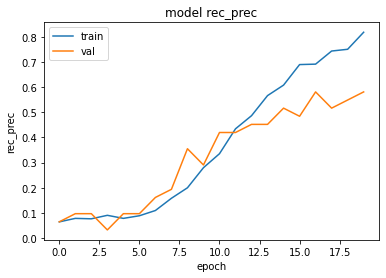

In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

         Из жизни       0.33      0.33      0.33         3
            Спорт       1.00      1.00      1.00         2
              Дом       1.00      1.00      1.00         2
             Крым       0.00      0.00      0.00         0
   Интернет и СМИ       0.50      0.50      0.50         2
   69-я параллель       0.00      0.00      0.00         1
  Наука и техника       0.50      0.67      0.57         3
       Библиотека       0.00      0.00      0.00         0
        Экономика       1.00      0.50      0.67         2
      Бывший СССР       0.67      0.67      0.67         3
           Бизнес       0.67      1.00      0.80         2
              Мир       0.00      0.00      0.00         1
         Культура       0.75      1.00      0.86         3
         Ценности       0.50      0.50      0.50         2
Силовые структуры       0.50      0.50      0.50         2
           Россия       0.00      0.00      0.00       

## bert-base-multilingual-cased



In [ ]:
# Мультиязычный берт
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
cased_model = TFAutoModel.from_pretrained('bert-base-multilingual-cased')

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)
    
    X.append(ids[:512])
  
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic, random_state=0)
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = cased_model({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
         epochs=20)


Epoch 1/20
288/288 [==============================] - 101s 320ms/step - loss: 2.8834 - accuracy: 0.0712 - rec_prec: 0.0000e+00 - val_loss: 2.7872 - val_accuracy: 0.0968 - val_rec_prec: 0.0645
Epoch 2/20
288/288 [==============================] - 90s 311ms/step - loss: 2.7587 - accuracy: 0.0885 - rec_prec: 0.0000e+00 - val_loss: 2.5427 - val_accuracy: 0.2258 - val_rec_prec: 0.0000e+00
Epoch 3/20
288/288 [==============================] - 90s 311ms/step - loss: 2.6477 - accuracy: 0.1840 - rec_prec: 0.0017 - val_loss: 2.2613 - val_accuracy: 0.2903 - val_rec_prec: 0.0968
Epoch 4/20
288/288 [==============================] - 89s 311ms/step - loss: 2.3697 - accuracy: 0.2969 - rec_prec: 0.0174 - val_loss: 1.9419 - val_accuracy: 0.5484 - val_rec_prec: 0.2903
Epoch 5/20
288/288 [==============================] - 89s 311ms/step - loss: 1.9391 - accuracy: 0.4115 - rec_prec: 0.0833 - val_loss: 1.5435 - val_accuracy: 0.5484 - val_rec_prec: 0.2581
Epoch 6/20
288/288 [==============================] 

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


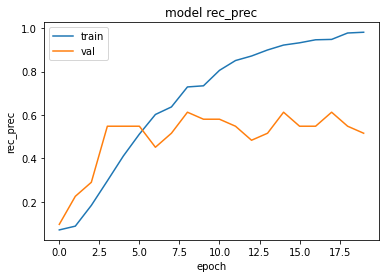

In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

         Из жизни       0.50      1.00      0.67         3
            Спорт       1.00      1.00      1.00         2
              Дом       1.00      1.00      1.00         2
             Крым       0.00      0.00      0.00         0
   Интернет и СМИ       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
  Наука и техника       0.40      0.67      0.50         3
       Библиотека       0.00      0.00      0.00         0
        Экономика       1.00      0.50      0.67         2
      Бывший СССР       0.50      0.67      0.57         3
           Бизнес       0.50      1.00      0.67         2
              Мир       0.00      0.00      0.00         1
         Культура       0.67      0.67      0.67         3
         Ценности       0.00      0.00      0.00         2
Силовые структуры       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00       

## LaBSE-en-ru

In [4]:

tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
bse_model = TFAutoModel.from_pretrained("cointegrated/LaBSE-en-ru", trainable=True, from_pt=True)



Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [5]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)
    
    X.append(ids[:512])
  
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [6]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic, random_state=0)
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [7]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = bse_model({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [8]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
         epochs=20)

Epoch 1/20
288/288 [==============================] - 94s 289ms/step - loss: 2.8645 - accuracy: 0.0851 - rec_prec: 0.0000e+00 - val_loss: 2.6412 - val_accuracy: 0.1935 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 82s 285ms/step - loss: 2.6654 - accuracy: 0.1615 - rec_prec: 0.0017 - val_loss: 2.3873 - val_accuracy: 0.3226 - val_rec_prec: 0.0323
Epoch 3/20
288/288 [==============================] - 82s 285ms/step - loss: 2.3031 - accuracy: 0.2951 - rec_prec: 0.0278 - val_loss: 1.8571 - val_accuracy: 0.5484 - val_rec_prec: 0.1935
Epoch 4/20
288/288 [==============================] - 82s 285ms/step - loss: 1.8917 - accuracy: 0.4236 - rec_prec: 0.1181 - val_loss: 1.5714 - val_accuracy: 0.5161 - val_rec_prec: 0.2581
Epoch 5/20
288/288 [==============================] - 82s 285ms/step - loss: 1.5034 - accuracy: 0.5469 - rec_prec: 0.3247 - val_loss: 1.3914 - val_accuracy: 0.4839 - val_rec_prec: 0.1613
Epoch 6/20
288/288 [==============================] - 82s

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


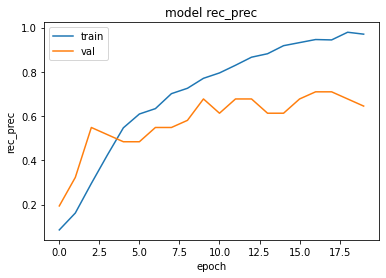

In [9]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

   Интернет и СМИ       0.00      0.00      0.00         2
            Спорт       1.00      1.00      1.00         2
       Библиотека       0.00      0.00      0.00         0
  Наука и техника       1.00      1.00      1.00         3
        Экономика       0.00      0.00      0.00         2
         Культура       0.67      0.67      0.67         3
Силовые структуры       0.67      1.00      0.80         2
              Мир       0.00      0.00      0.00         1
              Дом       1.00      1.00      1.00         2
           Бизнес       0.33      0.50      0.40         2
         Ценности       0.50      0.50      0.50         2
   69-я параллель       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
          Легпром       1.00      1.00      1.00         1
           Россия       1.00      0.50      0.67         2
         Из жизни       0.67      0.67      0.67       

Лучшие результаты у LaBSE-en-ru

# Задание 2 (2 балла)
Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):
 1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?
 2) Чем модель T5 отличается от ROBERTA/BERT?


1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?

Статья: [A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/pdf/1907.11692.pdf)
ROBERTA -- оптимизированный вариант BERT. 
ROBERTA обучается на большем количестве данных(16GB vs 160GB) и обучается дольше.
токенизация: RoBERTa: byte-level BPE; BERT: character-level BPE
Чтобы улучшить процедуру обучения, RoBERTa удаляет задачу «Предсказание следующего предложения» (NSP) из предварительной подготовки BERT и вводит динамическое маскирование, чтобы замаскированный токен изменялся в эпоху обучения.


2) Чем модель T5 отличается от ROBERTA/BERT?


T5 = Text-to-Text Transfer Transformer:
умеет не только понимать, но и генерировать тексты
построена как encoder-decoder, тогда как у BERT только encoder: каждая задача, включая перевод, ответы на вопросы и классификацию, представляет собой подачу текста в качестве входных данных и обучение созданию некоторого целевого текста. Это позволяет использовать одну и ту же модель, функцию потерь, гиперпараметры и т. д. в нашем разнообразном наборе задач.
